## Import Statements and Check


In [ ]:
! /opt/bin/nvidia-smi

Mon Nov 23 05:08:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
import tensorflow as tf
assert '2.' in tf.__version__  # make sure you're using tf 2.0
import numpy as np
import matplotlib.pyplot as plt
import math
import string
import pandas as pd
import sklearn
import skimage
import cv2 as cv
import os
import re
import datetime
import scipy
from skimage.morphology import reconstruction
from skimage import exposure
import scipy.io as sio
import seaborn as sns
import h5py
import random
import shutil
import PIL
import imageio
import copy
import pydot 
import graphviz
import plotly.graph_objects as go
import preprocess_crop
from pathlib import Path
from tensorflow.keras import backend as K
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
#from keras.utils import CustomObjectScope
from mpl_toolkits.mplot3d import Axes3D
print('Tensorflow version: ' + tf.__version__)
%matplotlib inline
%load_ext tensorboard

Tensorflow version: 2.3.0


Manually upload the randomly cropped data (from anther .ipynb file) and load the necessary .py files.

## Data Loading

## Padding Training Data and Adding Downsampled Image as Channel

In [ ]:
from standardize_dir_utils import pad_img_and_add_down_channel
from standardize_dir_utils import standardize_dir

In [ ]:
input_dir = '/content/data/train/input'
STANDARD_IMAGE_SHAPE = (128,128,1)
total_train_image_pool = standardize_dir(input_dir = input_dir, downsample_axis = 'x', downsample_ratio = [0,2], 
                                         standard_shape = STANDARD_IMAGE_SHAPE, file_format = '.tif')
print('total_train_image_pool = ' + str(total_train_image_pool))

total_train_image_pool = 908


In [ ]:
input_dir = '/content/data/val/input'
STANDARD_IMAGE_SHAPE = (128,128,1)
total_val_image_pool = standardize_dir(input_dir = input_dir, downsample_axis = 'x', downsample_ratio = [0,2], 
                                       standard_shape = STANDARD_IMAGE_SHAPE, file_format = '.tif')
print('total_val_image_pool = ' + str(total_val_image_pool))

total_val_image_pool = 114


In [ ]:
input_dir = '/content/data/test/input'
STANDARD_IMAGE_SHAPE = (128,128,1)
total_test_image_pool = standardize_dir(input_dir = input_dir, downsample_axis = 'x', downsample_ratio = [0,2], 
                                        standard_shape = STANDARD_IMAGE_SHAPE, file_format = '.tif')
print('total_test_image_pool = ' + str(total_test_image_pool))

total_test_image_pool = 113


## Model Testing and Training 

## Data Loader and Augmentation

In [ ]:
from data_aug_funcs import preprocess_function
from data_aug_funcs import preprocess_function_valtest
from data_aug_funcs import add_gaussian_noise

In [ ]:
STANDARD_IMAGE_SHAPE = (128,128,1) # See Above Section to Verify Shape
MIN_SHAPE = (STANDARD_IMAGE_SHAPE[0],STANDARD_IMAGE_SHAPE[1])
BATCH_SIZE = 16
train_dir = '/content/data/train'
val_dir = '/content/data/val'
test_dir = '/content/data/test'
seed = 7
tf.random.set_seed(seed)

In [ ]:
data_gen_args_train = dict(horizontal_flip=True,
                           vertical_flip = True,
                           rotation_range=20,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.2,
                           fill_mode = 'constant',
                           cval = 0,
                           preprocessing_function = preprocess_function,
                           dtype='float32')
train_datagen = ImageDataGenerator(**data_gen_args_train)
data_gen_args_test_and_val = dict(preprocessing_function = preprocess_function_valtest)
test_and_val_datagen = ImageDataGenerator(**data_gen_args_test_and_val)
# Flow From Directory Generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=MIN_SHAPE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode=None,
                                                    interpolation = 'lanczos:random',
                                                    color_mode='rgb',
                                                    shuffle = True, 
                                                    seed=seed)

validation_generator = test_and_val_datagen.flow_from_directory(val_dir,
                                                                target_size=MIN_SHAPE,
                                                                batch_size=BATCH_SIZE,
                                                                class_mode=None,
                                                                interpolation = 'lanczos:random',
                                                                color_mode='rgb',
                                                                shuffle = True, 
                                                                seed=seed)
test_generator = test_and_val_datagen.flow_from_directory(test_dir,
                                                          target_size=MIN_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode=None,
                                                          interpolation = 'lanczos:center', 
                                                          color_mode='rgb', 
                                                          shuffle = False,
                                                          seed=seed)

Found 908 images belonging to 1 classes.
Found 114 images belonging to 1 classes.
Found 113 images belonging to 1 classes.


In [ ]:
def custom_generator_wrapper(gen):
    '''
    This wrapper function ensures that the downsampled data and ground truth
    stay coaligned during the random crop step.
    '''
    for data in gen:
        orig_img = data[...,0] # target
        down_img = data[...,1] # input
        # Third channel is empty and only there for compatibility
        yield down_img[..., None], orig_img[..., None]

## U-Net Model Definition

In [ ]:
from FD_UNet import getModel
from model_utils import model_loss
from model_utils import PSNR
from model_utils import SSIM
from model_utils import KLDivergence
from model_utils import SavingMetric
from model_utils import model_loss_experimental

In [ ]:
EPOCHS = 150 #350
FILTERS = 64
INITIAL_LR = 0.001
ACTIVATION = 'elu'
KERNEL_SIZE = 3 # 3x3 kernel
AUGMENTATIONS = 10
VAL_AUGMENTATIONS = 10
B1 = 1.0
B2 = 0.01

In [ ]:
unet_model = getModel(input_shape=STANDARD_IMAGE_SHAPE, filters=FILTERS, kernel_size=KERNEL_SIZE, activation=ACTIVATION)

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = INITIAL_LR, amsgrad=False),  # pick an optimizer
                   loss=model_loss(B1,B2),  # pick a loss
                   #loss=model_loss_experimental(B1,B2,B3),
                   metrics=['mean_absolute_error', 'mean_squared_error', KLDivergence, SavingMetric, PSNR, SSIM])  # pick a metric to monitor

In [ ]:
train_dir = '/content/data/train/input'
val_dir = '/content/data/val/input'
model_dir = 'model_dir'
delete_previous=True

if not os.path.exists(model_dir):
            os.mkdir(model_dir)
elif delete_previous:
            shutil.rmtree(model_dir)
            os.mkdir(model_dir)

my_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(model_dir, 'saved_model.epoch_{epoch:02d}-SSIM_{val_SSIM:.5f}-PSNR_{val_PSNR:.5f}-metric_{val_SavingMetric:.5f}.h5'),
                                                   monitor='val_SavingMetric', verbose=0, 
                                                   save_best_only=True, save_weights_only=False, 
                                                   mode='min', save_freq='epoch')]

history = unet_model.fit(custom_generator_wrapper(train_generator),
                         steps_per_epoch=AUGMENTATIONS*np.ceil(len(os.listdir(train_dir))/BATCH_SIZE),
                         epochs=EPOCHS,
                         callbacks=my_callbacks, 
                         validation_data=custom_generator_wrapper(validation_generator),
                         validation_steps=VAL_AUGMENTATIONS*np.ceil(len(os.listdir(val_dir))/BATCH_SIZE), 
                         max_queue_size = 256,
                         shuffle = True)

Epoch 1/150
570/570 [==============================] - 201s 352ms/step - loss: 0.1362 - mean_absolute_error: 0.0985 - mean_squared_error: 0.0466 - KLDivergence: 0.0644 - SavingMetric: 0.7724 - PSNR: 15.5874 - SSIM: 0.3164 - val_loss: 0.0366 - val_mean_absolute_error: 0.0282 - val_mean_squared_error: 0.0014 - val_KLDivergence: 0.0207 - val_SavingMetric: 1.1282 - val_PSNR: 4.7341 - val_SSIM: 6.8862e-05
Epoch 2/150
570/570 [==============================] - 195s 343ms/step - loss: 0.0720 - mean_absolute_error: 0.0486 - mean_squared_error: 0.0045 - KLDivergence: 0.0158 - SavingMetric: 0.6103 - PSNR: 18.0071 - SSIM: 0.4696 - val_loss: 0.0999 - val_mean_absolute_error: 0.0925 - val_mean_squared_error: 0.0105 - val_KLDivergence: 0.0270 - val_SavingMetric: 1.1350 - val_PSNR: 2.8838 - val_SSIM: 4.0184e-06
Epoch 3/150
570/570 [==============================] - 194s 341ms/step - loss: 0.0596 - mean_absolute_error: 0.0409 - mean_squared_error: 0.0030 - KLDivergence: 0.0135 - SavingMetric: 0.5748 -

## Load the Best Model

In [ ]:
from model_utils import model_loss
from model_utils import PSNR
from model_utils import SSIM
from model_utils import KLDivergence
from model_utils import SavingMetric
print('Loading Best Model...')
model_dir = 'model_dir'
filename = sorted(os.listdir(model_dir), key = lambda x : int(x.partition('h_')[2].partition('-S')[0]))[-1]
directory = os.path.join(os.getcwd(), model_dir)
directory = os.path.join(directory, filename)
saved_model = tf.keras.models.load_model(directory, custom_objects={'model_loss':model_loss,'loss_func':model_loss(B1=0.99,B2=0.01), 
                                                                        'PSNR':PSNR, 'SSIM':SSIM, 'KLDivergence':KLDivergence, 
                                                                        'SavingMetric':SavingMetric})
print('Done Loading Best Model(' + filename + ') from: ' + model_dir)

Loading Best Model...
Done Loading Best Model(saved_model.epoch_22-SSIM_0.00305-PSNR_13.45961-metric_1.09346.h5) from: model_dir


## Analysis of Model Training History

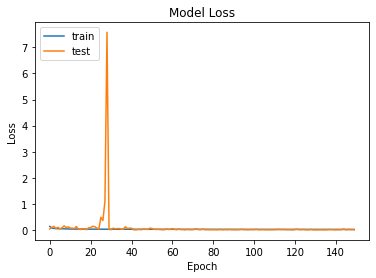

In [ ]:
offset = 0
data1 = history.history['loss'][offset:]
epochs = range(offset,len(data1)+offset)
plt.plot(epochs, data1)
data2 = history.history['val_loss'][offset:]
plt.plot(epochs, data2)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["train", "test"], loc = "upper left")
#plt.xticks(epochs)
plt.show()

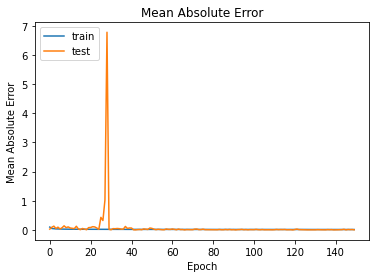

In [ ]:
offset = 0
data1 = history.history['mean_absolute_error'][offset:]
epochs = range(offset,len(data1)+offset)
plt.plot(epochs, data1)
data2 = history.history['val_mean_absolute_error'][offset:]
plt.plot(epochs, data2)
plt.title('Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(["train", "test"], loc = "upper left")
#plt.xticks(epochs)
plt.show()

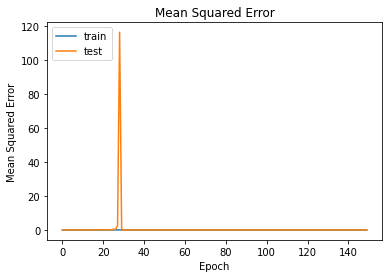

In [ ]:
offset = 0
data1 = history.history['mean_squared_error'][offset:]
epochs = range(offset,len(data1)+offset)
plt.plot(epochs, data1)
data2 = history.history['val_mean_squared_error'][offset:]
plt.plot(epochs, data2)
plt.title('Mean Squared Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(["train", "test"], loc = "upper left")
#plt.xticks(epochs)
plt.show()

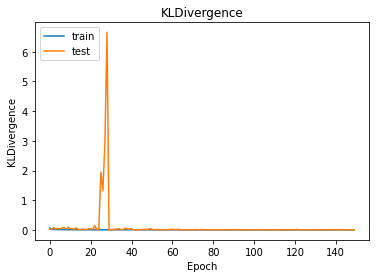

In [ ]:
offset = 0
data1 = history.history['KLDivergence'][offset:]
epochs = range(offset,len(data1)+offset)
plt.plot(epochs, data1)
data2 = history.history['val_KLDivergence'][offset:]
plt.plot(epochs, data2)
plt.title('KLDivergence')
plt.ylabel('KLDivergence')
plt.xlabel('Epoch')
plt.legend(["train", "test"], loc = "upper left")
#plt.xticks(epochs)
plt.show()

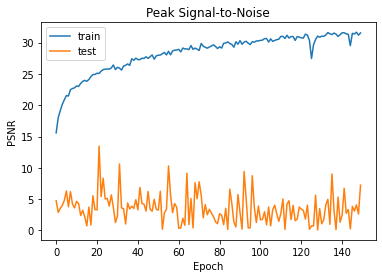

In [ ]:
offset = 0
data1 = history.history['PSNR'][offset:]
epochs = range(offset,len(data1)+offset)
plt.plot(epochs, data1)
data2 = history.history['val_PSNR'][offset:]
plt.plot(epochs, data2)
plt.title('Peak Signal-to-Noise')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend(["train", "test"], loc = "upper left")
#plt.xticks(epochs)
plt.show()

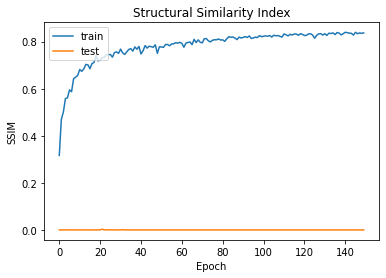

In [ ]:
offset = 0
data1 = history.history['SSIM'][offset:]
epochs = range(offset,len(data1)+offset)
plt.plot(epochs, data1)
data2 = history.history['val_SSIM'][offset:]
plt.plot(epochs, data2)
plt.title('Structural Similarity Index')
plt.ylabel('SSIM')
plt.xlabel('Epoch')
plt.legend(["train", "test"], loc = "upper left")
#plt.xticks(epochs)
plt.show()

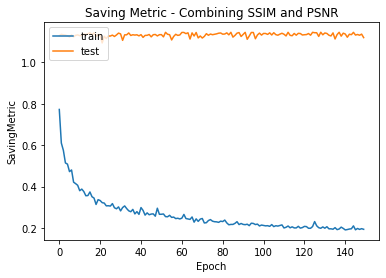

In [ ]:
offset = 0
data1 = history.history['SavingMetric'][offset:]
epochs = range(offset,len(data1)+offset)
plt.plot(epochs, data1)
data2 = history.history['val_SavingMetric'][offset:]
plt.plot(epochs, data2)
plt.title('Saving Metric - Combining SSIM and PSNR')
plt.ylabel('SavingMetric')
plt.xlabel('Epoch')
plt.legend(["train", "test"], loc = "upper left")
#plt.xticks(epochs)
plt.show()

## Model Architecture

In [ ]:
unet_model.summary()

Model: "FD-UNet_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 128, 128, 64) 640         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_92 (BatchNo (None, 128, 128, 64) 256         conv2d_89[0][0]                  
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 128, 128, 64) 4160        batch_normalization_92[0][0]     
______________________________________________________________________________________

# Applying Model to Larger Images

pick one complete OCT image and upload to a new folder

In [ ]:
import patchwork_alg
from patchwork_alg import expand_image
from patchwork_alg import fix_boundaries
from patchwork_alg import apply_model_patchwork
from standardize_dir_utils import pad_img_and_add_down_channel
from standardize_dir_utils import standardize_dir

Directory:/content/large/NORMAL-1038998-1.jpeg


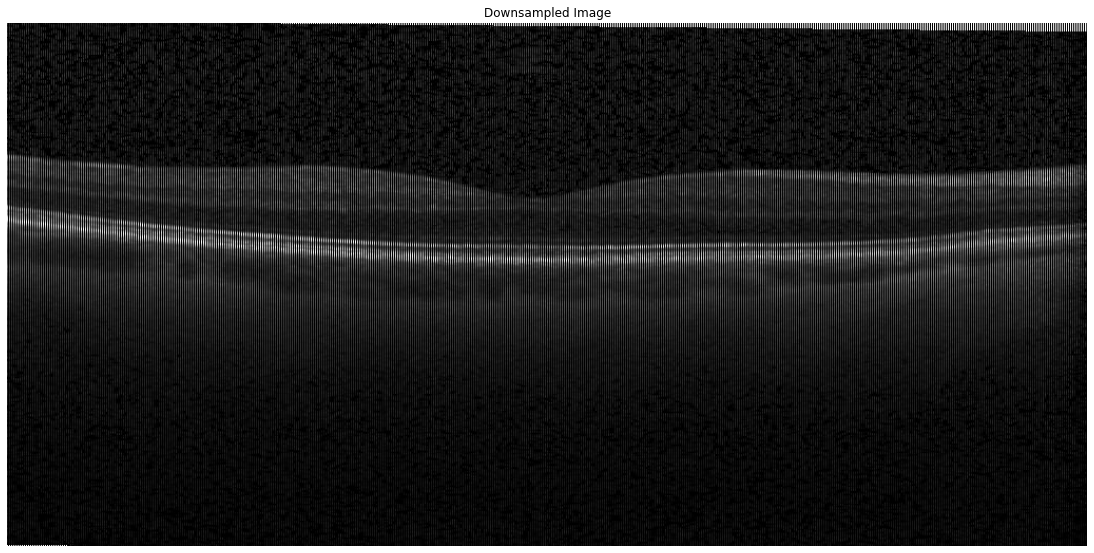

Augmented Shape: (496, 1024)
48.747007308467744 %


In [ ]:
dir_name = '/content/large'
file_list = os.listdir(dir_name)   
filename = os.fsdecode(file_list[0])
filepath = os.path.join(dir_name, filename)
print('Directory:' + filepath)
filepath = '/content/large/NORMAL-1038998-1.jpeg'
img = np.array(imageio.imread(filepath))
full = expand_image(down_image = img, downsampling_ratio = [0,2], downsampling_axis = 'both')
figsize = (15,15)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(full, cmap = 'gray')
plt.title('Downsampled Image')
plt.show()
print('Augmented Shape: ' + str(full.shape))
print(str((np.sum(full>0)/(full.shape[0]*full.shape[1]))*100) + ' %')

Directory: /content/large/NORMAL-1038998-1.jpeg


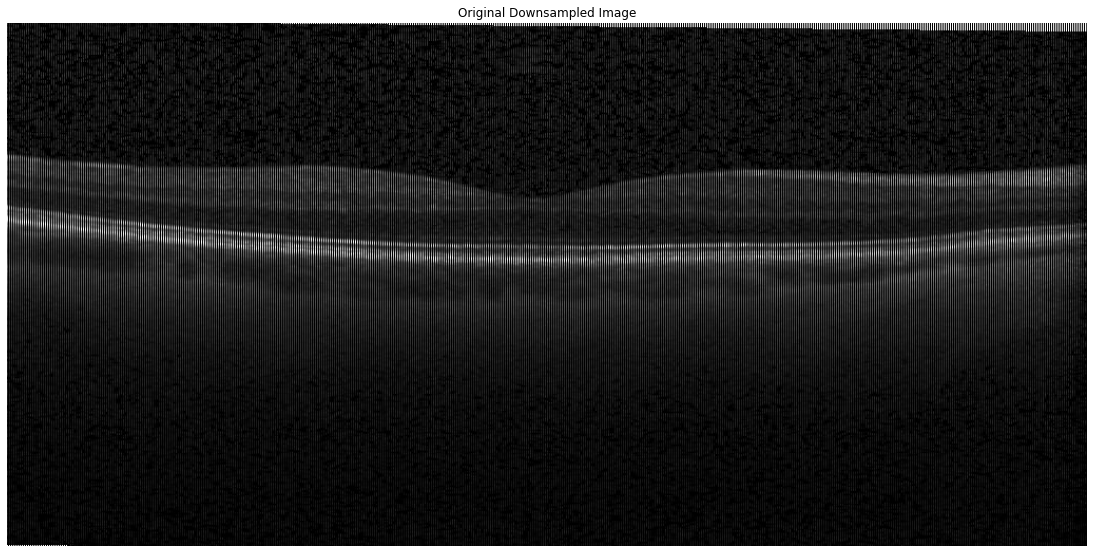

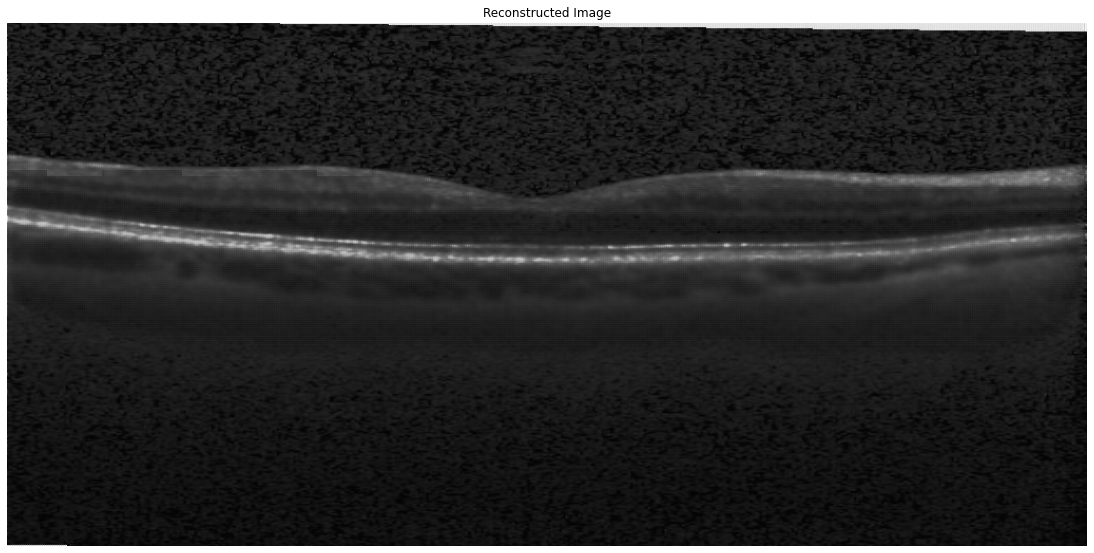

Augmented Shape: (496, 1024)
48.747007308467744 %


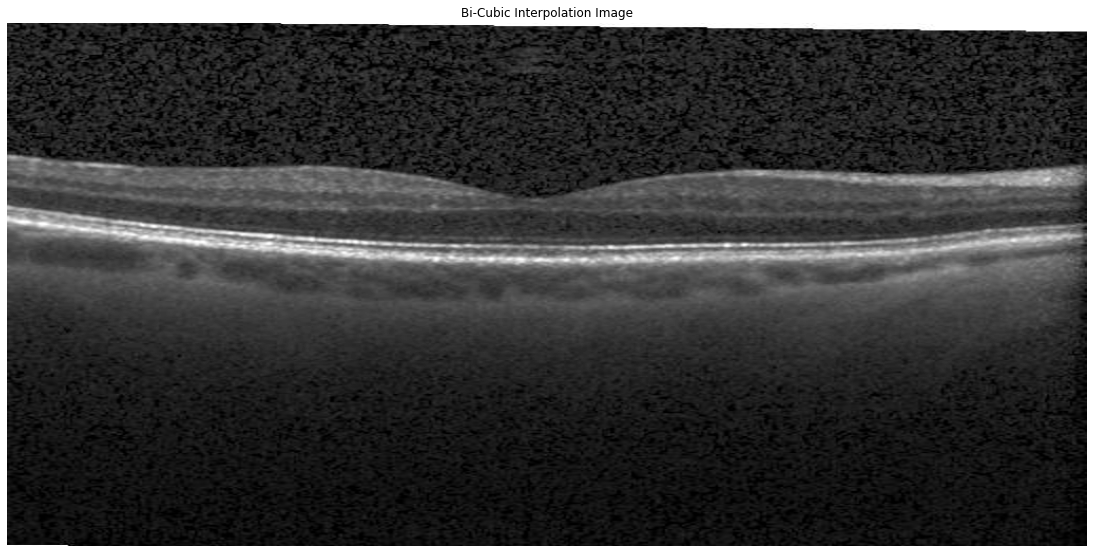

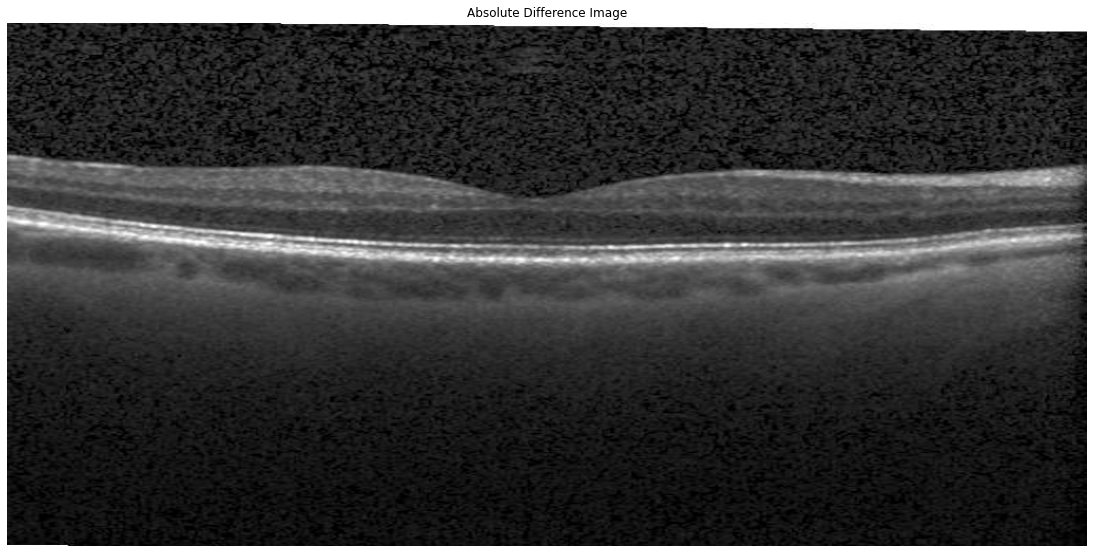

Mean Absolute Difference: 46.66137066739221
Max Absolute Difference: 254.30883402191836


In [ ]:
dir_name = '/content/large'
saved_model = saved_model
file_list = os.listdir(dir_name)   
filename = os.fsdecode(file_list[0])
filepath = os.path.join(dir_name, filename)
print('Directory: ' + filepath)
filepath = '/content/large/NORMAL-1038998-1.jpeg'
orig_img = np.array(imageio.imread(filepath))
img = orig_img
figsize = (15,15)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
full = expand_image(down_image = img, downsampling_ratio = [0,2], downsampling_axis = 'both')
ax.imshow(full, cmap = 'gray')
plt.title('Original Downsampled Image')
plt.show()
full_image = apply_model_patchwork(saved_model, down_image = img, downsampling_ratio = [0,2], 
                                   downsampling_axis = 'both', shape_for_model = (128,128), buffer = 20)
figsize = (15,15)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(full_image, cmap = 'gray')
plt.title('Reconstructed Image')
plt.show()
print('Augmented Shape: ' + str(full.shape))
print(str((np.sum(full>0)/(full.shape[0]*full.shape[1]))*100) + ' %')

i_expansion_ratio = 1
j_expansion_ratio = 2
interp_img = skimage.transform.resize(img, output_shape = (img.shape[0]*i_expansion_ratio,img.shape[1]*j_expansion_ratio), 
                                      order=3, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=True, 
                                      anti_aliasing_sigma=None)
figsize = (15,15)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(interp_img, cmap = 'gray')
plt.title('Bi-Cubic Interpolation Image')
plt.show()

# DIFFERENCE IMAGE:
figsize = (15,15)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(np.abs(interp_img - full_image), cmap = 'gray')
plt.title('Absolute Difference Image')
plt.show()
print('Mean Absolute Difference: ' + str(np.mean(np.abs(interp_img - full_image))))
print('Max Absolute Difference: ' + str(np.max(np.abs(interp_img - full_image))))